In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

import pandas as pd

##
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor  

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import mlflow
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle # Read and Save model - Serialization
from datetime import datetime

# custom functions
import sys
sys.path.append("/Users/java/Documents/10Acadamy/week - 3/Rossmann Pharmaceuticals")
from myscripts import util
from myscripts import plot

In [2]:
## Read Datas

store_file = '../data/store.csv'
test_file = '../data/test.csv'
train_file = '../data/train.csv'

In [3]:
train_df = pd.read_csv(train_file, parse_dates = True, low_memory = False)

In [4]:
test_df = pd.read_csv(test_file,parse_dates = True, low_memory = False)

### Preprocessing

In [5]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = util.add_month_year(train_df)
# train_df.isnull().sum()

INFO:root:util.py - Year, Month, Day, WeekOfYear for Dataframe


In [6]:
## Lable Date and StateHoiday Train 
lb_encode = LabelEncoder()
train_df['Date'] = lb_encode.fit_transform(train_df['Date'])
train_df['StateHoliday'] = lb_encode.fit_transform(train_df['StateHoliday'])
# train_df.info()

In [7]:
#### Save the train _file
train_df.to_csv('../data/train_with_features.csv', index=False)

In [8]:
### columns to use
columns = ['DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear']

In [9]:
sample_train = train_df.sample(1000)

train_x = sample_train[columns]
train_y = sample_train[['Sales']]

In [10]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X = x_scaler.fit_transform(train_x)
Y = y_scaler.fit_transform(train_y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


In [12]:
rf_reg = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=0)

In [13]:
score = rf_reg.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 45.57%


In [14]:
def train_model(X, Y, model_type='LinearRegression'):
    model = LinearRegression()
    
    if(model_type == 'RandomForest'):
        model = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0)
    
        
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        with mlflow.start_run(run_name=model_type, nested = True):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            print(f"Prediction Score of the {model_type} is {round(score * 100, 2)}%")
            
            if(model_type == 'LinearRegression'):
                mlflow.log_param('LR-Score', score)
                
            if(model_type == 'RandomForest'):
                mlflow.log_param('RF-Score', score)
                
            mlflow.sklearn.log_model(model, model_type +' Model')
            mlflow.end_run()
            
    print()

## Running this code will create multiple mflow models 
## Create a branch before running this file

# train_model(X, Y, "RandomForest")
# train_model(X, Y)

### Building models with sklearn pipelines

In [15]:
## sklearn pipeline
### columns to use
columns = ['DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear']
sample_train = train_df.sample(1000)

In [16]:
## Prepare the training and test features
x = sample_train[columns]
y = sample_train[['Sales']]

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2)

In [17]:
### Pipe Lines ###

rfr = Pipeline(steps=[
    ('scaler1', MinMaxScaler()),
    ('rfr_regretion', RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0))
])

lr = Pipeline(steps=[
    ('scaler2', MinMaxScaler()),
    ('lr_regretion', LinearRegression())
])

dt = Pipeline(steps=[
    ('scaler3', MinMaxScaler()),
    ('dt_regretion', DecisionTreeRegressor(random_state = 0)  )
])


In [18]:
rfr.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

Pipeline(steps=[('scaler3', MinMaxScaler()),
                ('dt_regretion', DecisionTreeRegressor(random_state=0))])

In [26]:
rfr_score = rfr.score(X_test, y_test)
lr_score = lr.score(X_test, y_test)
dt_score = dt.score(X_test, y_test)

print(f"Prediction Score of the RandomForestRegretion is {round(rfr_score * 100, 2)}%")
print(f"Prediction Score of the LinearRegretion is {round(lr_score * 100, 2)}%")
print(f"Prediction Score of the DecisionTree is {round(dt_score * 100, 2)}%")

# print(rfr_score)

Prediction Score of the RandomForestRegretion is 48.6%
Prediction Score of the LinearRegretion is 44.62%
Prediction Score of the DecisionTree is 36.79%


### Choose a loss function

In [21]:
rfr_prediction = rfr.predict(X_test)
lr_prediction = lr.predict(X_test)
dt_prediction = dt.predict(X_test)

rfr_rmse, rft_mae, _ = util.eval_metrics(y_test, rfr_prediction)
lr_rmse, lr_mae, _ = util.eval_metrics(y_test, lr_prediction)
dt_rmse, dt_mae, _ = util.eval_metrics(y_test, dt_prediction)


# print(f"Mean Absolute Loss : {round(mae * 100, 2)}%")
print(f"RandomForest Mean Square Loss : {round(rfr_rmse * 100, 2)}%")
print(f"Linear Mean Square Loss : {round(lr_rmse * 100, 2)}%")
print(f"DecisionTree Mean Square Loss : {round(dt_rmse * 100, 2)}%")

RandomForest Mean Square Loss : 293677.03%
Linear Mean Square Loss : 304822.73%
DecisionTree Mean Square Loss : 325656.21%


### Post Prediction analysis

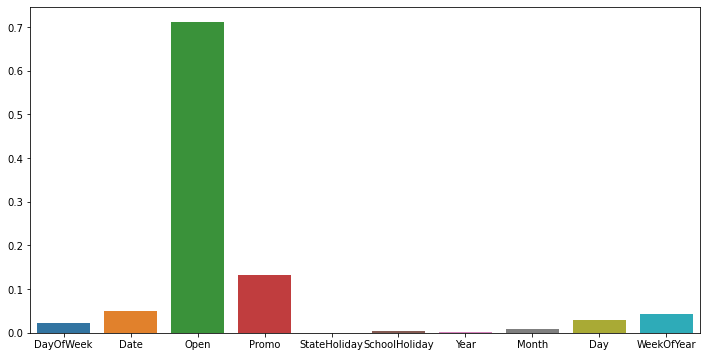

In [22]:
important_features = rfr[1].feature_importances_
plot.bar(columns, important_features)

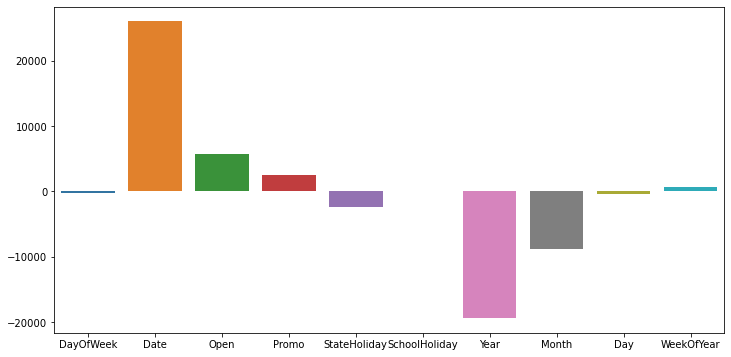

In [23]:
important_features = lr[1].coef_[0]
from matplotlib import pyplot as plt
plot.bar(columns, list(important_features))

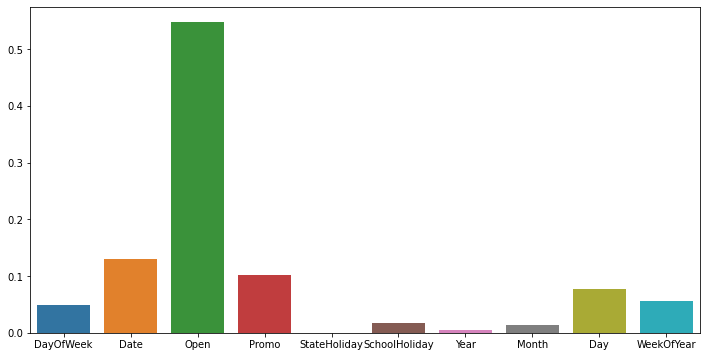

In [24]:
important_features = dt[1].feature_importances_
plot.bar(columns, important_features)

### Serialize models

In [ ]:
## use picke to dump mode
## decomment picke to save the model

reg_model_file_name = f'../models/reg-{datetime.now()}.pkl'
lr_model_file_name = f'../models/lt-{datetime.now()}.pkl'
dt_model_file_name = f'../models/dt-{datetime.now()}.pkl'

files = [reg_model_file_name, lr_model_file_name, dt_model_file_name]
models = [rfr, lr, dt]

print(reg_model_file_name)


# for i in range(len(files)):
#         pickle.dump(models[i], open(files[i], 'wb'))

In [ ]:
### Add the mlflow here
